# Cancer Cells Classification
### SVM vs KNN
- Source: Based on the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]
- Modified / Edited by: Edy Blau
- Date: 17/01/2025

This dataset contains information about human cells and their associated features, to classify them as `beningn` or `malignant`.

|Feature|Description|
|--- |--- |
|ID|ID|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

#### Upload the .csv file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, classification_report, confusion_matrix

In [2]:
import pandas as pd
df = pd.read_csv("datasets/cell_samples.csv")
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


- All the features range from 1 to 10, with 1 being the closest to `benign`.
- The class is represented by `benign` _(value = 2)_, and `malignant` _(value = 4)_.

Let's change the values in class to be represented as binary form.

`benign = 0`.

`malignant = 1`.

In [3]:
df['Class'] = df['Class'].replace({2:0, 4:1})

#### Basic Info and description of the DataFrame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           699 non-null    int64 
 1   Clump        699 non-null    int64 
 2   UnifSize     699 non-null    int64 
 3   UnifShape    699 non-null    int64 
 4   MargAdh      699 non-null    int64 
 5   SingEpiSize  699 non-null    int64 
 6   BareNuc      699 non-null    object
 7   BlandChrom   699 non-null    int64 
 8   NormNucl     699 non-null    int64 
 9   Mit          699 non-null    int64 
 10  Class        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [5]:
df.describe()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,0.344778
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.475636
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [6]:
df.shape

(699, 11)

#### Distribution of classes
(Based on Clump thickness and Uniformity)

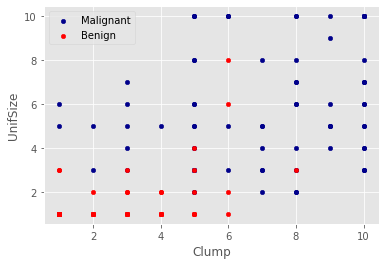

In [7]:
# First create a new axis
plt.style.use('ggplot')
ax = df[df['Class'] == 1][0:80].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='Malignant');
df[df['Class'] == 0][0:80].plot(kind='scatter', x='Clump', y='UnifSize', color='Red', label='Benign', ax=ax);

In [8]:
df.Class.value_counts()

0    458
1    241
Name: Class, dtype: int64

There are more instances of `Malignant` cells than `Benign` cells. It is necessary to consider this in the following steps.

#### Data pre-processing

In [9]:
df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks `BareNuc` is _object_ type. Let's drop the rows that are not numerical.

In [10]:
df = df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           683 non-null    int64
 1   Clump        683 non-null    int64
 2   UnifSize     683 non-null    int64
 3   UnifShape    683 non-null    int64
 4   MargAdh      683 non-null    int64
 5   SingEpiSize  683 non-null    int64
 6   BareNuc      683 non-null    int32
 7   BlandChrom   683 non-null    int64
 8   NormNucl     683 non-null    int64
 9   Mit          683 non-null    int64
 10  Class        683 non-null    int64
dtypes: int32(1), int64(10)
memory usage: 61.4 KB


#### Feature Selection

In [11]:
X = df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X.head()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


In [12]:
y = df['Class']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

#### Train/Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


#### Machine Learning Pipelines

In [14]:
# Defining the Pipelines
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1, random_state=42))
])

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

#### Training and Testing

In [15]:
# Training the model
svm_pipeline.fit(X_train, y_train)
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [16]:
# Predictions
y_pred_svm = svm_pipeline.predict(X_test)
y_pred_knn = knn_pipeline.predict(X_test)

#### Classification Report

In [17]:
# Classification Report
print('\nSVM Classification Report:')
print(classification_report(y_test, y_pred_svm))

print('\nKNN Classification Report:')
print(classification_report(y_test, y_pred_knn))


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        89
           1       0.92      0.98      0.95        48

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.96      0.96      0.96       137


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        89
           1       0.92      0.96      0.94        48

    accuracy                           0.96       137
   macro avg       0.95      0.96      0.95       137
weighted avg       0.96      0.96      0.96       137



#### Confusion Matrix

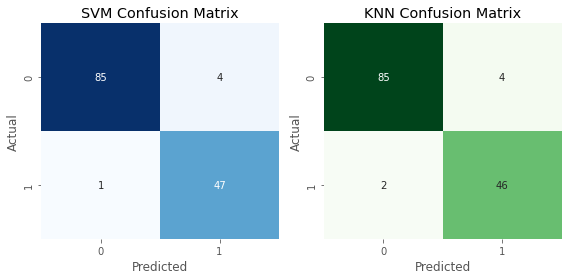

In [18]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# SVM Confusion Matrix
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# KNN Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_knn, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('KNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

According to the Classification Report and Confusion Matrices, both, _SVM_ and _KNN_ had a great performance, but `SVM` performed slightly better.